# BendyBevo
This notebook is intended to be a demonstration of the ability to solve equations directly on the mesh generated from a bitmap image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from utils import bitmapMeshHelper, gmsh2meshio

import dolfin as dl
import ufl
import meshio

import gmsh
from mpi4py import MPI

## Step 1: Mesh Creation.
- Load image.
- Threshold image to produce a bitmap.
- Extract image boundary.
- Create mesh at specified location with specified scale.
- Load mesh into Dolfin and visualize it.

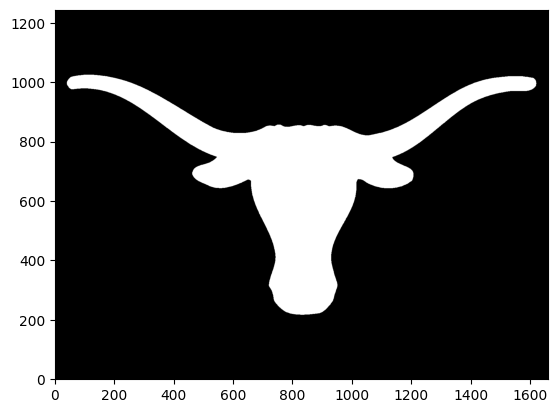

In [2]:
IMPATH = "longhorns.jpg"
im = cv2.imread(IMPATH, cv2.IMREAD_GRAYSCALE)
# Threshold the image to create a bitmap.
lh = ((im > 200) * 1).astype(np.uint8)[::-1]
plt.imshow(lh, cmap=plt.cm.gray, origin="lower")
plt.show()

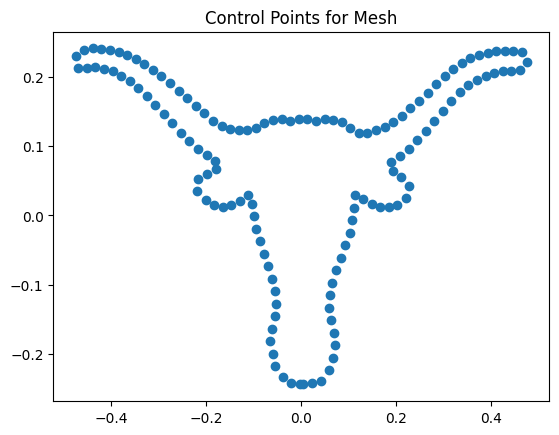

In [3]:
CX = 0
CY = 0
ORIGIN = np.array([CX, CY])
SCALE = 1. / np.max(lh.shape)
MESHFNAME = "mesh/horns.xdmf"

LHMH = bitmapMeshHelper(data=lh, scale=SCALE, origin=ORIGIN)
boundary = LHMH.getBoundary(method="opencv")

# try downsampling boundary
DOWNSAMPLE = 30
boundary = boundary[::DOWNSAMPLE]

plt.scatter(boundary[:,0], boundary[:,1])
plt.title("Control Points for Mesh")
plt.show()

In [4]:
gmsh.initialize()
gdim = 2
mesh_comm = MPI.COMM_WORLD
model_rank = 0
LCAR = 1e3

# Create points
points = [gmsh.model.occ.add_point(x=pt[0], y=pt[1], z=0., meshSize=LCAR) for pt in boundary]
# Create lines.
lines = [gmsh.model.occ.add_line(points[k], points[k+1]) for k in range(len(points)-1)]
lines.append(gmsh.model.occ.add_line(points[-1], points[0]))

#  ------------------
# Create (sp)lines.
# lines = [gmsh.model.occ.add_spline([points[k], points[k+1]]) for k in range(len(points)-1)]
# lines.append(gmsh.model.occ.add_spline([points[-1], points[0]]))
#  ------------------

# Create the curve loop.
bndryloop = [gmsh.model.occ.add_curve_loop(lines)]
# Add the surface.
s = gmsh.model.occ.add_plane_surface(bndryloop)

gmsh.model.occ.synchronize()

# We can constraint the min and max element sizes to stay within reasonnable
# values (see `t10.py' for more details):
gmsh.option.setNumber("Mesh.MeshSizeMin", 0.1)
gmsh.option.setNumber("Mesh.MeshSizeMax", 1.)


In [5]:
gmsh.model.mesh.generate(gdim)
gmsh.model.mesh.optimize("Netgen")
gmsh.write("mesh/horns.msh")
gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 10 (Line)
Info    : [ 10%] Meshing curve 11 (Line)
Info    : [ 10%] Meshing curve 12 (Line)
Info    : [ 10%] Meshing curve 13 (Line)
Info    : [ 10%] Meshing curve 14 (Line)
Info    : [ 10%] Meshing curve 15 (Line)
Info    : [ 20%] Meshing curve 16 (Line)
Info    : [ 20%] Meshing curve 17 (Line)
Info    : [ 20%] Meshing curve 18 (Line)
Info    : [ 20%] Meshing curve 19 (Line)
Info    : [ 20%] Meshing curve 20 (Line)
Info    : [ 20%] Meshing curve 21 (Line)
Info    : [ 20%] Meshing curve 22 (Line)
Info    : [ 20%] Meshing curve 23 (Line)
Info    : [ 20%] Meshing curve 24 (Line)
I

### Mesh creation using GMSH only instead of pygmsh.

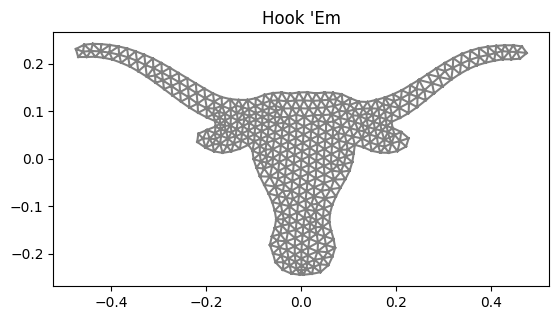

In [6]:
# ------ Convert mesh to xdmf for reading in dolfin ------ # 
MESHFNAME = "mesh/horns.msh"
mesh_from_file = meshio.read(MESHFNAME)
line_mesh = gmsh2meshio(mesh_from_file, "line", prune_z=True)
meshio.write("mesh/horns_facet_mesh.xdmf", line_mesh)
triangle_mesh = gmsh2meshio(mesh_from_file, "triangle", prune_z=True)
meshio.write("mesh/horns.xdmf", triangle_mesh)

mesh = dl.Mesh()
f = dl.XDMFFile(dl.MPI.comm_world, "mesh/horns.xdmf")
f.read(mesh)
f.close()
dl.plot(mesh)
plt.title("Hook 'Em")
plt.show()

## Step 2: Set up Elasticity Problem.

In [7]:
# Parameters.
mu = 1.
rho = 1.

beta = 1.25
lambda_ = beta

LOAD = -50.
CLAMP = dl.Constant((0., 0.))

# Define the function space.
V = dl.VectorFunctionSpace(mesh, "Lagrange", 1)

# Define the boundary condition.
nose = 'on_boundary && x[1]<-0.2'
bc = dl.DirichletBC(V, CLAMP, nose)

# Define the point loads.
lefthorn = dl.Point(-0.42, 0.23)
load1 = dl.PointSource(V.sub(1), lefthorn, LOAD)
righthorn = dl.Point(0.44, 0.23)
load2 = dl.PointSource(V.sub(1), righthorn, LOAD)

# Define strain and stress.
def epsilon(u):
    return 0.5*(dl.nabla_grad(u) + dl.nabla_grad(u).T)

def sigma(u):
    return lambda_*dl.div(u)*dl.Identity(u.geometric_dimension()) + 2*mu*epsilon(u)

### Define the Variational Problem

In [8]:
u = dl.TrialFunction(V)
v = dl.TestFunction(V)
f = dl.Constant((0., 0.))
ds = dl.Measure("ds", mesh)

# Variational forms.
a = dl.inner(sigma(u), epsilon(v))*ufl.dx
l = dl.dot(f, v)*ds

# System assembly.
K = dl.assemble(a)
b = dl.assemble(l)

# Apply loads.
load1.apply(b)
load2.apply(b)

# Apply boundary conditions.
bc.apply(K)
bc.apply(b)

### Solve the linear system

In [9]:
usol = dl.Function(V, name="Displacement")
dl.solve(K, usol.vector(), b)

1

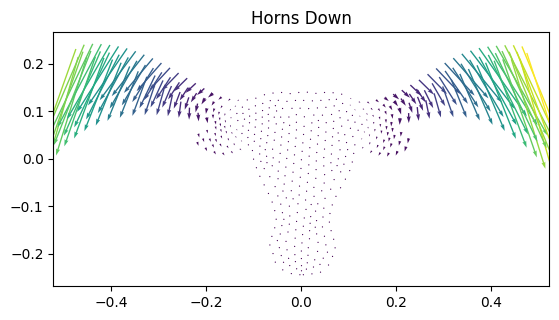

In [10]:
dl.plot(usol, title="Horns Down")
plt.show()

## Step 3: Plot the Stress Response

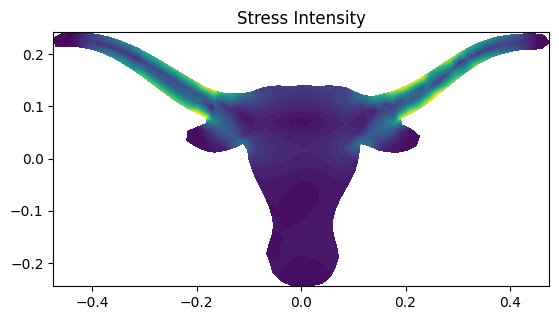

In [11]:
s = sigma(usol) - (1./3)*dl.tr(sigma(usol))*dl.Identity(usol.geometric_dimension())
vm = dl.sqrt(3./2*dl.inner(s, s))

P1 = dl.FunctionSpace(mesh, "Lagrange", 1)
vm = dl.project(vm, P1)
dl.plot(vm, title="Stress Intensity")
plt.show()

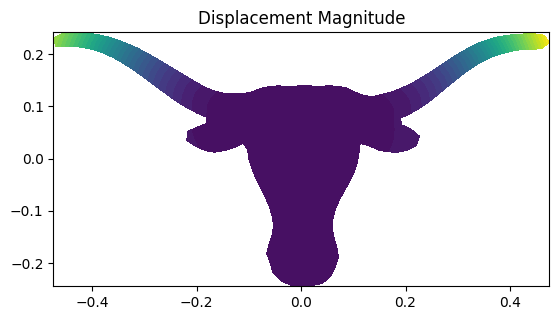

In [12]:
mag = dl.project(dl.sqrt(dl.dot(usol, usol)), P1)
dl.plot(mag, title="Displacement Magnitude")
plt.show()